In [1]:
import kornia
import torch
import matplotlib.pyplot as plt
import cv2
import numpy as np
import plot_inlier_matches

In [2]:
def get_paired_feature(img1_np,img2_np, n_pairs=500,n_features=5000):
    # takes two images, finds n_features using sift, finds pairs of featres and returns the top n_pairs 

    # Detect keypoints and extract descriptors
    sift = cv2.SIFT_create(nfeatures=n_features)
    kp1, des1 = sift.detectAndCompute(img1_np,None)
    kp2, des2 = sift.detectAndCompute(img2_np,None)
    
    des1 = torch.from_numpy(des1)
    des2 = torch.from_numpy(des2)
    dists, matches = kornia.feature.match_snn(des1, des2) #Match features

    #sort features and prune. keep the top n_pairs
    arg_sorts = dists.argsort(axis=0) 
    sorted_dists = dists[arg_sorts]
    sorted_matches = matches[arg_sorts]

    paired_feature = []
    
    for i in range(n_pairs):
        if i>=sorted_matches.shape[0]:
            break
        paired_feature.append(kp1[sorted_matches[i,0,0]].pt + kp2[sorted_matches[i,0,1]].pt)
    paired_feature = np.array(paired_feature)
    return paired_feature


In [3]:
def show(img):
    # used to show and resize image 
    imS = cv2.resize(img, (int(2400/3), int(2266/3)))               
    cv2.imshow("output", imS)                       
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [4]:
def show_inlier_matches(img1_np,img2_np,paired_feature):
    #used to show the feature pairs to on monitor
    fig, ax = plt.subplots(figsize=(20,10))
    h,w = img2_np.shape
    dummy_img2 = np.zeros(img1_np.shape)
    dummy_img2[:h,:w] = img2_np
    plot_inlier_matches.plot_inlier_matches(ax, img1_np ,dummy_img2, paired_feature)
    plt.figure()

In [5]:
def affine(points):
    # recieves AT LEAST 3 pair of points and finds affine X
    # to minimize ||AX-b|| 
    # if number of pairs is ecaxtly 3, finds the affine, other wise estimates using least-squared
    # why 3?
    #because: if we have 3 pairs, we have 6 rows and the equation bellow is solvable
    # | x_1 y_1 0     0     1  0 |   |T1| | x'_1 |
    # | x_2 y_2 0     0     1  0 |   |T2| | x'_2 |
    # |       .                  | @ |T3|=| .    |
    # |       .                  |   |T4| | .    |
    # | 0   0   x_N-1 y_N-1 0  1 |   |t1| |y'_N-1|
    # | 0   0   x_N   y_N   0  1 |   |t1| | y'_N |
    
    s = points.shape[0]
    if s<3:
        print("not enough points for afint")
        return None

    #create A and b
    base = np.array([[0,0,0,0,1,0],[0,0,0,0,0,1]])
    A = np.repeat(base,s ,axis=0)
    b = np.reshape(points[:,2:].T, (2*s,1))
    A[:s,:2] = points[:,:2]
    A[s:,2:4] = points[:,:2]

    #find psuedo inverse (if determinan is non zero)
    AT_A = A.T @ A
    if np.linalg.det(AT_A) == 0:
        return None
    x =  np.linalg.inv(AT_A) @ A.T @ b
    T = x[:4].reshape((2,2))
    t = x[4:]

    #reshap in to 3x3
    affine = np.concatenate((T,t),axis=1)
    affine = np.concatenate((affine,[[0,0,1]]))
    
    return affine
    

In [6]:
def homography(points):
    # same idea as the affine function
    # needs 4 pairs to find a homography.
    # if gets more than 4, calculates the best one using least squared
    # uses SVD instead of pseudo inverse to solve 
    s = points.shape[0]
    if s<4:
        print("not enough points for homo")
        return None
    base = np.array([[0,0,1,0,0,0,0,0,0],[0,0,0,0,0,1,0,0,0]])
    A = np.repeat(base,s ,axis=0)
    
    A[:s,:2] = points[:,:2]
    A[s:,3:5] = points[:,:2]

    A[:s,6:] = -np.diag(points[:,2]) @ A[:s,:3]
    A[s:,6:] = -np.diag(points[:,3]) @ A[:s,:3]

    try:
        U,S,V = np.linalg.svd(A)
    except:
        print ("no existo")
        return None
    ssv = V[len(V)-1]
    homography = ssv.reshape((3,3))
    
    return homography

In [7]:
def find_best_transform(img1_np, img2_np, n_pairs=500,n_features=5000, p=5, N=100, trans="affine",show_image=True):
    # finds the best affine, or homography of two images (based on value of trans)
    # n_pairs is the number of top feature pairs that will be selected. 
    # n_features number of total features calculated by sift
    # p : the distance for RANSAC to count as an inlier
    # N : number of iterations of RANSAC
    if trans not in {"affine","homography"}:
        print("trans field not valid")
        return None
    
    paired_feature = get_paired_feature(img1_np,img2_np, n_pairs=n_pairs,n_features=5000)
    if show_image:
        show_inlier_matches(img1_np,img2_np,paired_feature)

    # translate the pairs in to homogenious coordinates. we will later use this to find inliers in ransac
    feats1_homo = paired_feature[:,:2]
    feats1_homo = np.concatenate((feats1_homo, np.ones((feats1_homo.shape[0],1))),axis=1)
    feats2_homo = paired_feature[:,2:]
    feats2_homo = np.concatenate((feats2_homo, np.ones((feats1_homo.shape[0],1))),axis=1)

    # keep track of the model with most number of inliers
    max_votes = 0
    max_mask = None
    
    cur=0
    samples = paired_feature.shape[0]
    while cur<N: #repeat ransac N times
        if trans == "affine":
            chosens = np.random.randint(low=0, high=samples, size=3, dtype=int) #3 is minimum needed for affine
            M = affine(paired_feature[chosens])
        elif trans == "homography":
            chosens = np.random.randint(low=0, high=samples, size=4, dtype=int) #4 is minimum needed for homography
            M = homography(paired_feature[chosens])
        
        if M is None:
            print("determinant is zero, retry")
            continue
        cur+=1
    
        transformed = (M @ (feats1_homo.T)).T #apply the transformation to all the points.
        transformed = transformed/transformed[:,2:3] #devide by z if needed (homogenious, need to normalize)

        #after applying the transform to all points, find their distance from their pairs.
        #if its less than p, count them as inliers, other wise outliers
        dists = np.square(feats2_homo-transformed) 
        dists = np.sum(dists, axis=1)
    
        mask = dists < p
        votes = np.sum(mask)
        if votes>max_votes:
            max_votes = votes
            max_mask = mask

    #after N iterations, using the inliers, find the best transformation using least_squared
    if trans == "affine":
        best_matrix = affine(paired_feature[max_mask])
    elif trans == "homography":
        best_matrix = homography(paired_feature[max_mask])
    return best_matrix

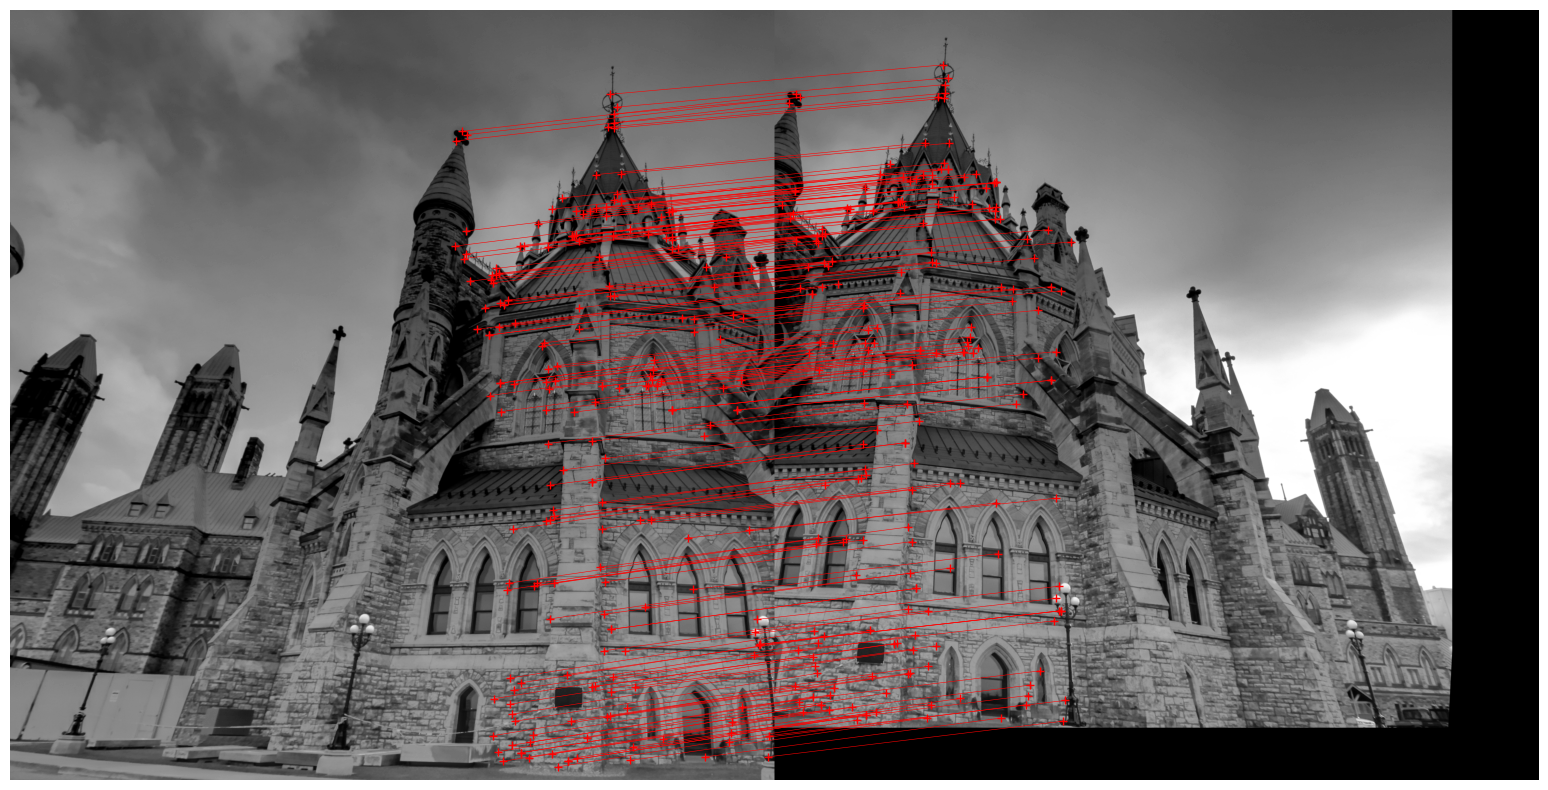

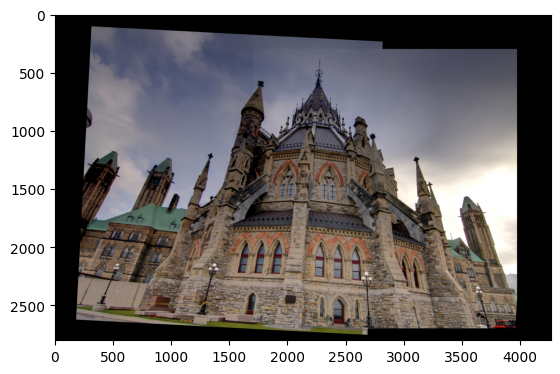

In [8]:
#preprocessing
img1_read = cv2.imread('parliament/parliament-left.jpg')
img2_read = cv2.imread('parliament/parliament-right.jpg')

img1_np = cv2.cvtColor(img1_read,cv2.COLOR_BGR2GRAY)
img2_np = cv2.cvtColor(img2_read,cv2.COLOR_BGR2GRAY)

best_affine_matrix = find_best_transform(img1_np,
                                         img2_np,
                                         n_pairs=200,
                                         n_features=5000,
                                         p=5,
                                         N=100,
                                         trans="affine")

affine_mat = torch.tensor(best_affine_matrix.reshape((1,3,3)))

img1 = cv2.cvtColor(img1_read,cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2_read,cv2.COLOR_BGR2RGB)

img1 = kornia.utils.image_to_tensor(img1, False).float() / 255.
img2 = kornia.utils.image_to_tensor(img2, False).float() / 255.

h,w,_ = img2_read.shape
f_h,f_w = 2*200 + h, 2*1000 + w #add padding to both sided of the image

translation = torch.eye(3)
translation = translation.reshape((1,3,3))
translation[0,1,2],translation[0,0,2] = 300, 1700 #translate the panaroma to be in the middle

mosaic = kornia.geometry.warp_perspective(img2, translation,(f_h, f_w))
img_t = kornia.geometry.warp_perspective(img1, translation @ affine_mat.float(),(f_h, f_w))

mosaic_fin = torch.maximum(mosaic, img_t) #find max of the images

plt.imshow(kornia.tensor_to_image(mosaic_fin))
# plt.imsave("parlimant_affine.jpg", kornia.tensor_to_image(mosaic_fin))

In [9]:
hall_l_BGR = cv2.imread('YU_Glendon-hall/Glendon-Hall-left.jpg')
hall_m_BGR = cv2.imread('YU_Glendon-hall/Glendon-Hall-middle.jpg')
hall_r_BGR = cv2.imread('YU_Glendon-hall/Glendon-Hall-right.jpg')


hall_l = cv2.cvtColor(hall_l_BGR,cv2.COLOR_BGR2GRAY)
hall_m = cv2.cvtColor(hall_m_BGR,cv2.COLOR_BGR2GRAY)
hall_r = cv2.cvtColor(hall_r_BGR,cv2.COLOR_BGR2GRAY)

In [10]:
best_homography_l_m = find_best_transform(hall_l,
                                          hall_m,
                                          n_pairs=300,
                                          n_features=5000,
                                          p=5, N=200,
                                          trans="homography",
                                         show_image=False)
best_homography_r_m = find_best_transform(hall_r,
                                          hall_m,
                                          n_pairs=300,
                                          n_features=5000,
                                          p=5,
                                          N=200,
                                          trans="homography",
                                         show_image=False)

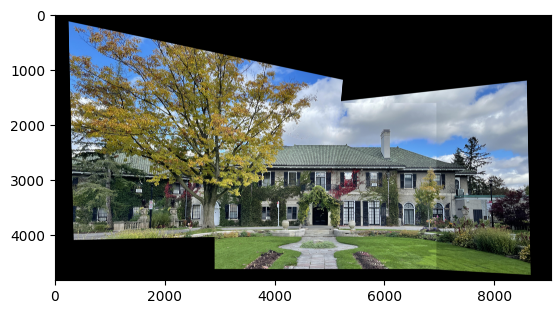

In [11]:
img_rgb_l = cv2.cvtColor(hall_l_BGR,cv2.COLOR_BGR2RGB)
img_rgb_m = cv2.cvtColor(hall_m_BGR,cv2.COLOR_BGR2RGB)
img_rgb_r = cv2.cvtColor(hall_r_BGR,cv2.COLOR_BGR2RGB)


img_rgb_l = kornia.utils.image_to_tensor(img_rgb_l, False).float() / 255.
img_rgb_m = kornia.utils.image_to_tensor(img_rgb_m, False).float() / 255.
img_rgb_r = kornia.utils.image_to_tensor(img_rgb_r, False).float() / 255.

h,w,_ = hall_m_BGR.shape
f_h,f_w = 2*900 + h, 2*2500 + w #padd, make final panaroma bigger

translation = torch.eye(3)
translation = translation.reshape((1,3,3))
translation[0,1,2],translation[0,0,2] = 1600, 2900 #translate to center

homo_l_m = torch.tensor(best_homography_l_m.reshape((1,3,3))).float()
homo_r_m = torch.tensor(best_homography_r_m.reshape((1,3,3))).float()

img_m = kornia.geometry.warp_perspective(img_rgb_m, translation ,(f_h, f_w))
img_lm = kornia.geometry.warp_perspective(img_rgb_l, translation @ homo_l_m,(f_h, f_w))
img_rm = kornia.geometry.warp_perspective(img_rgb_r, translation @ homo_r_m,(f_h, f_w))

stack = torch.stack((img_m,img_lm,img_rm))
mosaic = torch.amax(stack, axis=0).float()

plt.imshow(kornia.tensor_to_image(mosaic))

In [12]:
# plt.imsave("glenden_panarama.jpg", kornia.tensor_to_image(mosaic))

In [13]:
pic1_o = cv2.imread('demon/pic1.jpg')
pic2_o = cv2.imread('demon/pic2.jpg')
pic3_o = cv2.imread('demon/pic3.jpg')


pic1 = cv2.cvtColor(pic1_o,cv2.COLOR_BGR2GRAY)
pic2 = cv2.cvtColor(pic2_o,cv2.COLOR_BGR2GRAY)
pic3 = cv2.cvtColor(pic3_o,cv2.COLOR_BGR2GRAY)

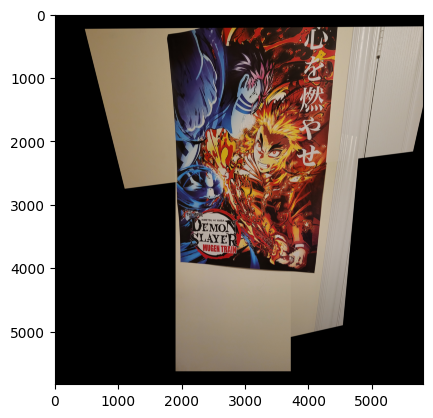

In [14]:
best_homography_l_m = find_best_transform(pic1,
                                          pic2,
                                          n_pairs=300,
                                          n_features=5000,
                                          p=5, N=200,
                                          trans="homography",
                                         show_image=False)
best_homography_r_m = find_best_transform(pic3,
                                          pic2,
                                          n_pairs=300,
                                          n_features=5000,
                                          p=5,
                                          N=200,
                                          trans="homography",
                                         show_image=False)
img_rgb_l = cv2.cvtColor(pic1_o,cv2.COLOR_BGR2RGB)
img_rgb_m = cv2.cvtColor(pic2_o,cv2.COLOR_BGR2RGB)
img_rgb_r = cv2.cvtColor(pic3_o,cv2.COLOR_BGR2RGB)


img_rgb_l = kornia.utils.image_to_tensor(img_rgb_l, False).float() / 255.
img_rgb_m = kornia.utils.image_to_tensor(img_rgb_m, False).float() / 255.
img_rgb_r = kornia.utils.image_to_tensor(img_rgb_r, False).float() / 255.

h,w,_ = pic2_o.shape
f_h,f_w = 2*900 + h, 2*2000 + w

translation = torch.eye(3)
translation = translation.reshape((1,3,3))
translation[0,1,2],translation[0,0,2] = 1600, 1900

homo_l_m = torch.tensor(best_homography_l_m.reshape((1,3,3))).float()
homo_r_m = torch.tensor(best_homography_r_m.reshape((1,3,3))).float()

img_m = kornia.geometry.warp_perspective(img_rgb_m, translation ,(f_h, f_w))
img_lm = kornia.geometry.warp_perspective(img_rgb_l, translation @ homo_l_m,(f_h, f_w))
img_rm = kornia.geometry.warp_perspective(img_rgb_r, translation @ homo_r_m,(f_h, f_w))

stack = torch.stack((img_m,img_lm,img_rm))
mosaic = torch.amax(stack, axis=0).float()

plt.imshow(kornia.tensor_to_image(mosaic))
# my this picture came out a bit funky. my poster isnt fully planer, theirs some air under it, so the middle parts
# of the poster looks a bit wiered 
# plt.imsave("demon_slayer.jpg", kornia.tensor_to_image(mosaic))